# Assignment 4

Lucas Bezerra, ID: 171412, lucas.camaradantasbezerra@kaust.edu.sa

### Problem 1: Questions
<!--
<strong>Q1. GDPP [1] targets increasing the diversity of the generated data to match real data. GDPP is based on Determinants Point Processes [2], which is an elegant probabilistic model that measures how representative a selected subset S is for the entire set: P(S ⊆ Y ) ∝ det(LS), where LS is a diversity kernel on the subset S. Given a subset of data S and a feature extraction function ϕ(·), GDPP constructs LS as: LS = Φ(S)${}^T$ Φ(S). What does this kernel measure and how it is influenced when the selected subset are similar versus different from one another?</strong> 
-->

Q1:

The kernel measures the diversity/similarity of a subset S sampled from Y; its diagonal contains the probabilities of items of the set Y being selected, while the elements off-diagonal are inversely proportional to the likelihood of a pair of elements appearing together. Basically it measures how likely the elements of a set are of being selected, given the other elements. Similar kernels indicate that the sets were sampled from the same distribution.

Q2:

We want the fake and real images to have similar distributions, which implies similar diversity kernels. Each kernel is a matrix, and one way of measuring matrix similarity is by measuring how close their eigenvalues and eigenvectors are. That is what GDPP pursues: the $\mathcal{L}_m$ loss minimizes the square difference between the pairs of eigenvalues (ordered by magnitude), and the $\mathcal{L}_s$ loss maximizes the inner product between pairs of eigenvectors (higher when vectors are closer), weighted by their respective normalized eigenvalues. Optimizing for both losses simultaneously is important since: similar eigenvalues but different eigenvectors implies very different matrices, just as different eigenvalues but similar eigenvectors.

Q3:

The "toRGB" block in the generator converts the (W x H x C) feature vector to a (W x H x 3) one, such that the image can be shown in the RGB format in the latent representation, while the "fromRGB" block in the discriminator does the opposite, expading the number of channels from 3 to C. 

The $\alpha$ parameter ensures stability during the network's growth phase. It acts as a weight on the new higher resolution block; it starts at 0, when the higher res. block has no impact on the result, and slowly increases up to 1, when the higher res. block takes over completely from the previous one. 

Q4:

While standard instance normalization has learnable parameters $\mu$ and $\sigma$, in AdaIN there is an extra "style" argument $\mathbf{y}$ instead of learnable parameters. $\mu$ and $\sigma$ are then given by the mean and covariance matrix of $\mathbf{y}$, respectively. The style vector $\mathbf{y}$ is generated by an affine transformation (learnable, block-specific) that is applied on the latent vector $\mathbf{w}$ generated by the mapping function, a sequence of fully-connected layers (learnable, image-specific).

Q5:

- **Revisited AdaIN**: Changing normalization to improve performance;
- **Replaced Progressive with Skip Connections**: Some distortions showed up due to the early training phase, where the resolution is low; they were solved by implementing skip connections from the beginning;
- **Path Length Normalization**: A regularization term that enforces that the generator gradient with respect to the latent space is constant regardless of w itself; makes generator more smooth and better-conditioned.

Q6:

The paper shows that the "Augment D(iscriminator) only" strategy (not to use augmentation when training the generator) fails as the the discriminator's task becomes much harder than the generator's, and thus rendering the problem unbalanced. "Augment reals only" is also not recommended since it changes the "target distribution" we want the generator to fit to. The paper shows that only simple augmentations work in this case, and more complex ones produce unwanted distortions. The failure of the past strategies lead to the Differentiable Augmentation (augment reals and fakes when training both generator and discriminator), which seems more successful.

### Problem 2: Coding Assignment

In this coding assignment, you are requested to implement the Conditional GAN to make your model generates some MNIST images given the numbers you want.
In detail, you need to implement the generator and the discriminator part.
You will notice that the framework here is quite similar to assignment 3.
But now, both the generator and the discriminator additionally take the numbers you want as input.
You can build upon your last implementation.
Fill the code in the file model.py and train the model.

Here are some example results
![title](example.png)


In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torch.utils.data as data_utils
from torchvision.datasets.mnist import MNIST

from model import Generator, Discriminator
from train import train_conditionGAN

device = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

Hyperparameters are listed here. You maybe need to play a little bit with.

In [2]:
g_lr = 0.0002
d_lr = 0.0002
batch_size = 128
num_epochs = 10

In [3]:
trans = transforms.Compose([
            transforms.Scale(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, )),
        ])

train_set = MNIST(root='.', train=True, transform=trans, download=True)
train_loader = data_utils.DataLoader(train_set, batch_size=batch_size, shuffle=True)


/home/camaral/miniconda3/envs/gan_course/lib/python3.9/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


[0/10][0/469]	Loss_D: 1.3820	Loss_G: 0.9117	D(x): 0.5014	D(G(z)): 0.4990 / 0.4021
[0/10][50/469]	Loss_D: 0.0010	Loss_G: 8.1090	D(x): 0.9997	D(G(z)): 0.0007 / 0.0003
[0/10][100/469]	Loss_D: 0.0002	Loss_G: 9.5378	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/10][150/469]	Loss_D: 0.0001	Loss_G: 9.8329	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/10][200/469]	Loss_D: 0.0001	Loss_G: 10.1391	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[0/10][250/469]	Loss_D: 0.0000	Loss_G: 11.3340	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][300/469]	Loss_D: 0.0042	Loss_G: 10.6185	D(x): 0.9959	D(G(z)): 0.0000 / 0.0001
[0/10][350/469]	Loss_D: 0.3973	Loss_G: 3.5232	D(x): 0.9517	D(G(z)): 0.2660 / 0.0350
[0/10][400/469]	Loss_D: 0.7231	Loss_G: 2.2054	D(x): 0.7599	D(G(z)): 0.3235 / 0.1308
[0/10][450/469]	Loss_D: 0.6622	Loss_G: 2.5388	D(x): 0.7278	D(G(z)): 0.2479 / 0.0957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


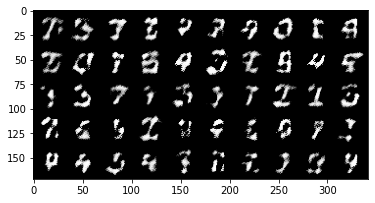

[1/10][0/469]	Loss_D: 2.1995	Loss_G: 1.3680	D(x): 0.1495	D(G(z)): 0.0244 / 0.2850
[1/10][50/469]	Loss_D: 0.5440	Loss_G: 3.1750	D(x): 0.8728	D(G(z)): 0.3084 / 0.0525
[1/10][100/469]	Loss_D: 0.3890	Loss_G: 3.1493	D(x): 0.8907	D(G(z)): 0.2251 / 0.0491
[1/10][150/469]	Loss_D: 0.3281	Loss_G: 2.3616	D(x): 0.8005	D(G(z)): 0.0735 / 0.1225
[1/10][200/469]	Loss_D: 1.0718	Loss_G: 1.4309	D(x): 0.4237	D(G(z)): 0.0819 / 0.2768
[1/10][250/469]	Loss_D: 0.8194	Loss_G: 1.4345	D(x): 0.7650	D(G(z)): 0.3962 / 0.2573
[1/10][300/469]	Loss_D: 0.1675	Loss_G: 2.6822	D(x): 0.9660	D(G(z)): 0.1196 / 0.0852
[1/10][350/469]	Loss_D: 0.3069	Loss_G: 2.6888	D(x): 0.8972	D(G(z)): 0.1686 / 0.0780
[1/10][400/469]	Loss_D: 0.6610	Loss_G: 0.5054	D(x): 0.6004	D(G(z)): 0.0849 / 0.6249
[1/10][450/469]	Loss_D: 0.7877	Loss_G: 0.2328	D(x): 0.5336	D(G(z)): 0.0421 / 0.8079


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


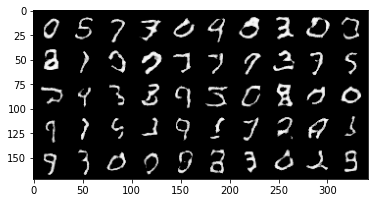

[2/10][0/469]	Loss_D: 0.2786	Loss_G: 1.8154	D(x): 0.8590	D(G(z)): 0.1060 / 0.1968
[2/10][50/469]	Loss_D: 0.9025	Loss_G: 1.3155	D(x): 0.6437	D(G(z)): 0.3315 / 0.2867
[2/10][100/469]	Loss_D: 0.3556	Loss_G: 2.2396	D(x): 0.8854	D(G(z)): 0.1956 / 0.1245
[2/10][150/469]	Loss_D: 0.9239	Loss_G: 1.6434	D(x): 0.7266	D(G(z)): 0.4086 / 0.2114
[2/10][200/469]	Loss_D: 0.2489	Loss_G: 2.5912	D(x): 0.8932	D(G(z)): 0.1193 / 0.0896
[2/10][250/469]	Loss_D: 0.3094	Loss_G: 1.8927	D(x): 0.9083	D(G(z)): 0.1764 / 0.1857
[2/10][300/469]	Loss_D: 0.4312	Loss_G: 2.1702	D(x): 0.8820	D(G(z)): 0.2328 / 0.1481
[2/10][350/469]	Loss_D: 0.5037	Loss_G: 2.0285	D(x): 0.8539	D(G(z)): 0.2620 / 0.1581
[2/10][400/469]	Loss_D: 0.7053	Loss_G: 1.1458	D(x): 0.6377	D(G(z)): 0.1300 / 0.3815
[2/10][450/469]	Loss_D: 0.1720	Loss_G: 3.0519	D(x): 0.9319	D(G(z)): 0.0893 / 0.0620


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


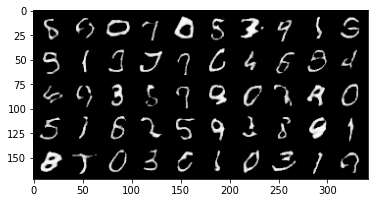

[3/10][0/469]	Loss_D: 0.6247	Loss_G: 2.4365	D(x): 0.8644	D(G(z)): 0.3089 / 0.1065
[3/10][50/469]	Loss_D: 0.5658	Loss_G: 2.6074	D(x): 0.9292	D(G(z)): 0.3398 / 0.0950
[3/10][100/469]	Loss_D: 0.2550	Loss_G: 3.5259	D(x): 0.9667	D(G(z)): 0.1768 / 0.0397
[3/10][150/469]	Loss_D: 0.6102	Loss_G: 1.1875	D(x): 0.6228	D(G(z)): 0.0191 / 0.4041
[3/10][200/469]	Loss_D: 0.7995	Loss_G: 3.2793	D(x): 0.9477	D(G(z)): 0.4640 / 0.0443
[3/10][250/469]	Loss_D: 0.1341	Loss_G: 3.5180	D(x): 0.9672	D(G(z)): 0.0876 / 0.0440
[3/10][300/469]	Loss_D: 0.2017	Loss_G: 3.3171	D(x): 0.9307	D(G(z)): 0.1073 / 0.0525
[3/10][350/469]	Loss_D: 0.1394	Loss_G: 4.2702	D(x): 0.9808	D(G(z)): 0.1006 / 0.0242
[3/10][400/469]	Loss_D: 1.3789	Loss_G: 0.6948	D(x): 0.3314	D(G(z)): 0.0592 / 0.5582
[3/10][450/469]	Loss_D: 0.2236	Loss_G: 3.0622	D(x): 0.9055	D(G(z)): 0.0971 / 0.0668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


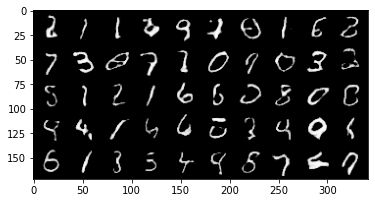

[4/10][0/469]	Loss_D: 0.3768	Loss_G: 2.4907	D(x): 0.8768	D(G(z)): 0.1869 / 0.1164
[4/10][50/469]	Loss_D: 0.3802	Loss_G: 3.1095	D(x): 0.9374	D(G(z)): 0.2338 / 0.0571
[4/10][100/469]	Loss_D: 0.0667	Loss_G: 3.8536	D(x): 0.9673	D(G(z)): 0.0297 / 0.0323
[4/10][150/469]	Loss_D: 0.0424	Loss_G: 4.9139	D(x): 0.9974	D(G(z)): 0.0362 / 0.0118
[4/10][200/469]	Loss_D: 1.1012	Loss_G: 0.8526	D(x): 0.5929	D(G(z)): 0.4110 / 0.4435
[4/10][250/469]	Loss_D: 0.6218	Loss_G: 1.8648	D(x): 0.7215	D(G(z)): 0.1782 / 0.2163
[4/10][300/469]	Loss_D: 1.0286	Loss_G: 1.0720	D(x): 0.4753	D(G(z)): 0.0286 / 0.4496
[4/10][350/469]	Loss_D: 0.0996	Loss_G: 3.6278	D(x): 0.9911	D(G(z)): 0.0826 / 0.0421
[4/10][400/469]	Loss_D: 0.1514	Loss_G: 3.3524	D(x): 0.9303	D(G(z)): 0.0620 / 0.0530
[4/10][450/469]	Loss_D: 0.0533	Loss_G: 4.8177	D(x): 0.9668	D(G(z)): 0.0099 / 0.0154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


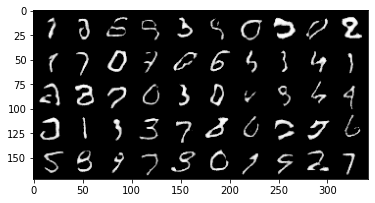

[5/10][0/469]	Loss_D: 0.0189	Loss_G: 5.2025	D(x): 0.9895	D(G(z)): 0.0081 / 0.0094
[5/10][50/469]	Loss_D: 0.0058	Loss_G: 6.6148	D(x): 0.9965	D(G(z)): 0.0023 / 0.0030
[5/10][100/469]	Loss_D: 0.0037	Loss_G: 6.8608	D(x): 0.9980	D(G(z)): 0.0017 / 0.0049
[5/10][150/469]	Loss_D: 1.0763	Loss_G: 2.0198	D(x): 0.7931	D(G(z)): 0.5229 / 0.1583
[5/10][200/469]	Loss_D: 0.6930	Loss_G: 1.4286	D(x): 0.7339	D(G(z)): 0.2593 / 0.2943
[5/10][250/469]	Loss_D: 0.6180	Loss_G: 1.6271	D(x): 0.6952	D(G(z)): 0.1183 / 0.2520
[5/10][300/469]	Loss_D: 0.5127	Loss_G: 0.6545	D(x): 0.6940	D(G(z)): 0.0584 / 0.6027
[5/10][350/469]	Loss_D: 0.5149	Loss_G: 4.5804	D(x): 0.9708	D(G(z)): 0.3127 / 0.0162
[5/10][400/469]	Loss_D: 0.3302	Loss_G: 3.6680	D(x): 0.9578	D(G(z)): 0.2048 / 0.0411
[5/10][450/469]	Loss_D: 0.2397	Loss_G: 2.1845	D(x): 0.9032	D(G(z)): 0.1094 / 0.1624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


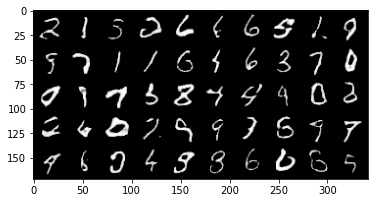

[6/10][0/469]	Loss_D: 0.0941	Loss_G: 4.3515	D(x): 0.9785	D(G(z)): 0.0589 / 0.0196
[6/10][50/469]	Loss_D: 0.0588	Loss_G: 5.4363	D(x): 0.9953	D(G(z)): 0.0489 / 0.0077
[6/10][100/469]	Loss_D: 0.0191	Loss_G: 5.6402	D(x): 0.9925	D(G(z)): 0.0108 / 0.0083
[6/10][150/469]	Loss_D: 0.0398	Loss_G: 6.4185	D(x): 0.9993	D(G(z)): 0.0331 / 0.0030
[6/10][200/469]	Loss_D: 0.0032	Loss_G: 6.6341	D(x): 0.9976	D(G(z)): 0.0008 / 0.0031
[6/10][250/469]	Loss_D: 1.1285	Loss_G: 1.6367	D(x): 0.4276	D(G(z)): 0.0693 / 0.2506
[6/10][300/469]	Loss_D: 0.5066	Loss_G: 1.4976	D(x): 0.7022	D(G(z)): 0.0618 / 0.3396
[6/10][350/469]	Loss_D: 0.3051	Loss_G: 2.0023	D(x): 0.8283	D(G(z)): 0.0807 / 0.2102
[6/10][400/469]	Loss_D: 0.4529	Loss_G: 1.9841	D(x): 0.7878	D(G(z)): 0.1500 / 0.1727
[6/10][450/469]	Loss_D: 0.0960	Loss_G: 3.6152	D(x): 0.9407	D(G(z)): 0.0180 / 0.0452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


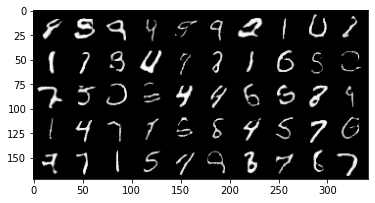

[7/10][0/469]	Loss_D: 0.0312	Loss_G: 5.2093	D(x): 0.9796	D(G(z)): 0.0065 / 0.0083
[7/10][50/469]	Loss_D: 0.0278	Loss_G: 5.2582	D(x): 0.9786	D(G(z)): 0.0033 / 0.0125
[7/10][100/469]	Loss_D: 0.0080	Loss_G: 6.5573	D(x): 0.9964	D(G(z)): 0.0041 / 0.0023
[7/10][150/469]	Loss_D: 0.0045	Loss_G: 6.5176	D(x): 0.9999	D(G(z)): 0.0042 / 0.0050
[7/10][200/469]	Loss_D: 0.0089	Loss_G: 6.7952	D(x): 0.9930	D(G(z)): 0.0014 / 0.0022
[7/10][250/469]	Loss_D: 0.0052	Loss_G: 7.5660	D(x): 0.9966	D(G(z)): 0.0017 / 0.0015
[7/10][300/469]	Loss_D: 1.1961	Loss_G: 0.8586	D(x): 0.5595	D(G(z)): 0.4391 / 0.4329
[7/10][350/469]	Loss_D: 0.6329	Loss_G: 1.9641	D(x): 0.7901	D(G(z)): 0.2843 / 0.1808
[7/10][400/469]	Loss_D: 1.0902	Loss_G: 0.6744	D(x): 0.4431	D(G(z)): 0.0605 / 0.5837
[7/10][450/469]	Loss_D: 0.7217	Loss_G: 1.0933	D(x): 0.6129	D(G(z)): 0.1077 / 0.4201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


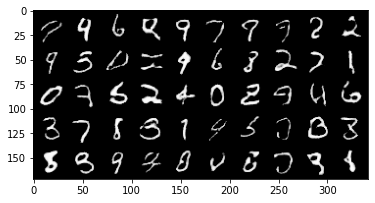

[8/10][0/469]	Loss_D: 0.5202	Loss_G: 1.6009	D(x): 0.7357	D(G(z)): 0.1280 / 0.2858
[8/10][50/469]	Loss_D: 0.4790	Loss_G: 1.5755	D(x): 0.7099	D(G(z)): 0.0469 / 0.3005
[8/10][100/469]	Loss_D: 0.2118	Loss_G: 3.5264	D(x): 0.9388	D(G(z)): 0.1146 / 0.0519
[8/10][150/469]	Loss_D: 0.1464	Loss_G: 3.4150	D(x): 0.9193	D(G(z)): 0.0485 / 0.0636
[8/10][200/469]	Loss_D: 0.1079	Loss_G: 3.9591	D(x): 0.9733	D(G(z)): 0.0697 / 0.0303
[8/10][250/469]	Loss_D: 0.0316	Loss_G: 4.2950	D(x): 0.9934	D(G(z)): 0.0209 / 0.0271
[8/10][300/469]	Loss_D: 0.0180	Loss_G: 5.2206	D(x): 0.9865	D(G(z)): 0.0041 / 0.0100
[8/10][350/469]	Loss_D: 1.2452	Loss_G: 0.8365	D(x): 0.5411	D(G(z)): 0.4417 / 0.4413
[8/10][400/469]	Loss_D: 0.6540	Loss_G: 1.5273	D(x): 0.7528	D(G(z)): 0.2557 / 0.2807
[8/10][450/469]	Loss_D: 0.5199	Loss_G: 2.2645	D(x): 0.8786	D(G(z)): 0.2682 / 0.1573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


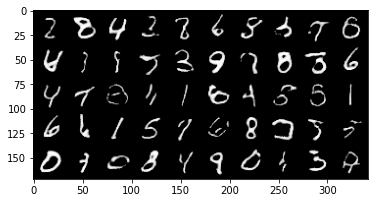

[9/10][0/469]	Loss_D: 0.6062	Loss_G: 1.6973	D(x): 0.6900	D(G(z)): 0.1141 / 0.2753
[9/10][50/469]	Loss_D: 0.2510	Loss_G: 1.9545	D(x): 0.8575	D(G(z)): 0.0716 / 0.2231
[9/10][100/469]	Loss_D: 0.1525	Loss_G: 4.2496	D(x): 0.9502	D(G(z)): 0.0830 / 0.0206
[9/10][150/469]	Loss_D: 0.0349	Loss_G: 4.9308	D(x): 0.9821	D(G(z)): 0.0150 / 0.0199
[9/10][200/469]	Loss_D: 0.0113	Loss_G: 5.3867	D(x): 0.9975	D(G(z)): 0.0087 / 0.0084
[9/10][250/469]	Loss_D: 0.0145	Loss_G: 6.3666	D(x): 0.9882	D(G(z)): 0.0024 / 0.0033
[9/10][300/469]	Loss_D: 0.0062	Loss_G: 6.7451	D(x): 0.9952	D(G(z)): 0.0013 / 0.0022
[9/10][350/469]	Loss_D: 0.0129	Loss_G: 6.0629	D(x): 0.9900	D(G(z)): 0.0018 / 0.0105
[9/10][400/469]	Loss_D: 0.5903	Loss_G: 2.1459	D(x): 0.7289	D(G(z)): 0.1621 / 0.1886
[9/10][450/469]	Loss_D: 0.7896	Loss_G: 0.9209	D(x): 0.5942	D(G(z)): 0.0771 / 0.5205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


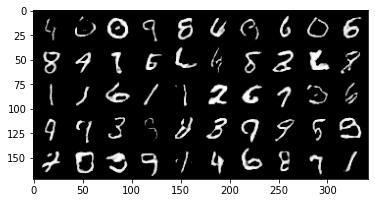

In [4]:
# The training part. Due to the easy dataset and simplified model structure, the training is relatively fast.
# In my case (Single Titan RTX) the training is finished in about 10 minutes.
# You may need to balance the training of generator and discriminator (e.g. by tuning their learning rates) to
# avoid a discriminator that is much stronger than the generator during training


G = Generator().to(device)
D = Discriminator().to(device)

optim_G = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))

loss_f = nn.BCELoss()

train_conditionGAN(G, D, optim_G, optim_D, loss_f, train_loader, num_epochs, device)